In [10]:
# setup

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon as PolygonPatch
from shapely.geometry import Point, Polygon
import numpy as np
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 9)

# DC Statehood!
UNREPRESENTED = ['District of Columbia', 'Puerto Rico']

# Hawaii has 8 main islands but several tiny atolls that extend for a thousand miles.
# This is the area cutoff between the 8 main islands and the tiny atolls.
ATOLL_CUTOFF = 0.005

# Alaska is big!
AL_SCALE = 0.35

# Coordinates for translating Alaska and Hawaii
AL_TRANS_X = 1100000
AL_TRANS_Y = -1300000
HI_TRANS_X = 5200000
HI_TRANS_Y = -1400000

### Creating a plot of the United States ###

Create a basemap object and import the shape files. We need to translate Alaska and Hawaii manually to show them on the map and handle the many tiny islands of Hawaii carefully.

References:

http://stackoverflow.com/questions/39742305/how-to-use-basemap-python-to-plot-us-with-50-states

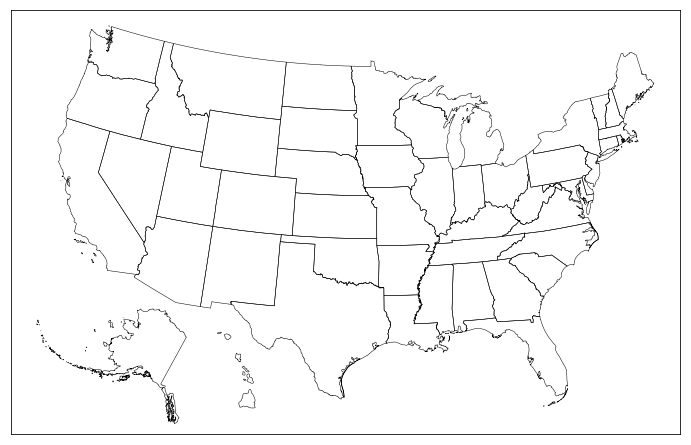

In [11]:
# Build the basemap object
m = Basemap(llcrnrlon=-121,llcrnrlat=20,urcrnrlon=-62,urcrnrlat=49,
        projection='lcc',lat_1=32,lat_2=45,lon_0=-95)

# load the shapefile, use the name 'states'
m.readshapefile('data/st99_d00', name='states', drawbounds=True)

ax = plt.gca()

def translate_alaska_hawaii(m, ax):
    """ Translate Alaska and Hawaii so that they show on the map.
    
    Args:
        m: (Basemap): The basemap pre-loaded with state info
        ax (matplotlib.axes): The axes for which to draw Alaska and Hawaii
    """
    for shapedict in m.states_info:
        name = shapedict['NAME']
        # Translate the noncontiguous states:
        if name in ['Alaska', 'Hawaii']:
            seg = m.states[int(shapedict['SHAPENUM'] - 1)]
            # Only include the 8 main islands of Hawaii so that we don't put dots in the western states.
            if name == 'Hawaii' and float(shapedict['AREA']) > ATOLL_CUTOFF:
                seg = list(map(lambda (x,y): (x + HI_TRANS_X, y + HI_TRANS_Y), seg))
            # Alaska is large. Rescale it.
            elif name == 'Alaska':
                seg = list(map(lambda (x,y): (AL_SCALE * x + AL_TRANS_X, AL_SCALE * y + AL_TRANS_Y), seg))
            poly = PolygonPatch(seg, facecolor='white', edgecolor='black', linewidth=.5)
            ax.add_patch(poly)

translate_alaska_hawaii(m, ax)
plt.show()

### Put random points in a state ###

1. Find a bounding box for the state.
2. Generate a random point inside that bounding box.
3. Save the point if it is inside the state.
4. Repeat steps 2 & 3 until the required number of points are found.

Be careful to handle states made of multiple polygons.

Inspired by http://ilyasterin.com/blog/2010/05/random-points-in-polygon-generation-algorithm.html and 
http://stackoverflow.com/questions/21612976/point-inside-polygon

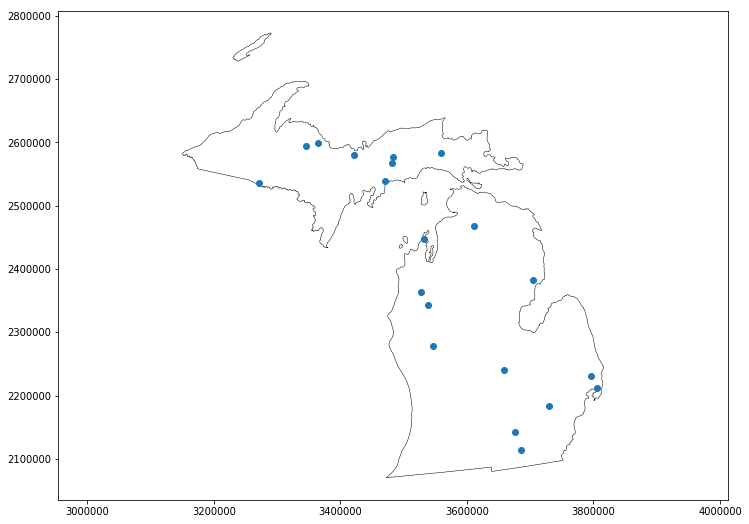

In [12]:
# Test using Michigan because it has 7 chunks.

# Consolidate the polys and add them to a plot
state_polys = []
fig, ax = plt.subplots()
for shapedict in m.states_info:
    if shapedict['NAME'] == 'Michigan':
        poly = np.array(m.states[int(shapedict['SHAPENUM'] - 1)])
        state_polys.append(poly)
        state_patch = PolygonPatch(poly, facecolor='white', edgecolor='black', linewidth=.5)
        ax.add_patch(state_patch)

ax.axis('equal')

def state_points(state_polys, num):
    """ Generate a list of random points inside the state. Handle the case of states
    with non-contiguous chunks.
    
    Args:
        state_polys (list of np.array): list of arrays of 2D points making up the state
        num (int): Number of points to generate
        
    Returns:
        two lists of floats, first is the x coordinates, second
        is the y coordinates.
    """
    points = [[], []]
    
    while len(points[0]) < num:

        # Find bounding box
        state = np.vstack(state_polys)
        swcrnr = (np.min(state[:,0]), np.min(state[:,1]))
        necrnr = (np.max(state[:,0]), np.max(state[:,1]))
        width = necrnr[0] - swcrnr[0]
        height = necrnr[1] - swcrnr[1]

        # Generate random point in bounding box
        x = swcrnr[0] + width * np.random.rand()
        y = swcrnr[1] + height * np.random.rand()

        # Check if it is inside one of the polys
        pt = Point(x, y)
        polys = [Polygon(p) for p in state_polys]
        if any([poly.contains(pt) for poly in polys]):
            points[0].append(x)
            points[1].append(y)
            
    return points

points = state_points(state_polys, 20)
plt.plot(points[0], points[1], 'o')
plt.show()

### Put points in all the states ###

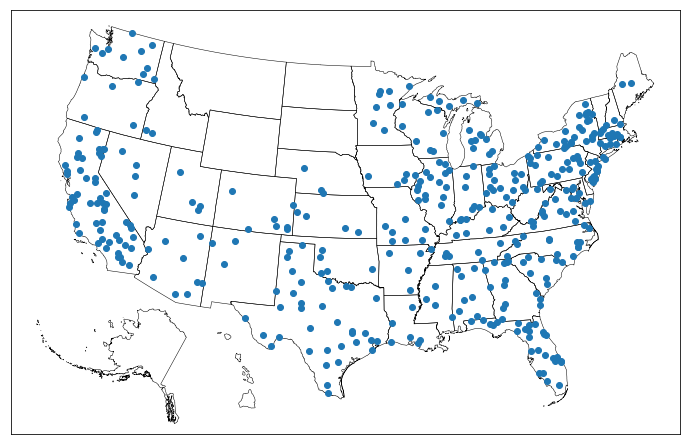

In [13]:
import csv

# build a dictionary with number of districts by state name
with open('data/districts_by_state_113th.csv') as h:
    reader = csv.reader(h)
    districts = {k:v for k,v in reader}

points = [[],[]]

m = Basemap(llcrnrlon=-121,llcrnrlat=20,urcrnrlon=-62,urcrnrlat=49,
        projection='lcc',lat_1=32,lat_2=45,lon_0=-95)

# load the shapefile, use the name 'states'
m.readshapefile('data/st99_d00', name='states', drawbounds=True)

# consolidate the shapes into polygons
state_polys = {}
for shapedict in m.states_info:
    name = shapedict['NAME']
    # Skip the "states" that are, shamefully, unrepresented.
    if name in UNREPRESENTED:
        continue
    poly = np.array(m.states[int(shapedict['SHAPENUM'] - 1)])
    try:
        state_polys[name].append(poly)
    except KeyError:
        state_polys[name] = [poly]
        
# now loop over the consolidated states
for name, polys in state_polys.items():
    num_districts = int(districts[name])
    if num_districts > 1:
        spoints = state_points(polys, num_districts)
        points[0] += spoints[0]
        points[1] += spoints[1]

translate_alaska_hawaii(m, plt.gca())

plt.plot(points[0], points[1], 'o')
plt.show()